## Synthetic Map Production thoughts

When producing power-law power-spectrum maps, we end up with intensity-only distributions.  What different approaches can we take for the velocity distribution?  What effects do those choices have?  Are they consistent w/turbulent simulations?  w/observations?

1. 3D powerspectrum cube of density, velocity follows density gradient exactly (local mass approximation?)
2. 3D powerspectrum cube of density, do full gravity vector calculations for each point (how different, if at all, is that from (1)?
3. 3D powerspectrum cube of density, independent cube of velocity?
4. 6D powerspectrum cube of density-velocity?  That doesn't even make sense; maybe 4D....

In [1]:
%matplotlib inline
import pylab as pl
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['image.interpolation'] = 'none'

In [27]:
from turbustat import simulator
from turbustat.statistics import psds
from astropy import units as u, constants
from scipy import ndimage

### Create a 3D field and upscale it to 65$^3$ for gradient calcs below 

In [12]:
field = simulator.make_3dfield(imsize=64, powerlaw=3,)
# we want a positive density field
field -= field.min()
upsample_field = ndimage.interpolation.map_coordinates(field, np.mgrid[:65,:65,:65]/64.*63.)

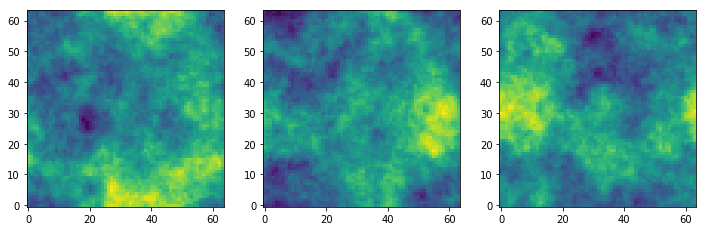

In [13]:
pl.figure(figsize=(12,4))
pl.subplot(1,3,1).imshow(field.mean(axis=0))
pl.subplot(1,3,2).imshow(field.mean(axis=1))
pl.subplot(1,3,3).imshow(field.mean(axis=2))

In [14]:
scale = 1e4*u.au
density = 1000*u.Da / u.cm**3
nfield = (density * field/field.mean())
mfield = (nfield * scale**3).to(u.M_sun)
upsample_nfield = (density * upsample_field/upsample_field.mean())
upsample_mfield = (upsample_nfield * scale**3).to(u.M_sun)

In [15]:
(f"Total mass: {mfield.sum()}, mean mass={mfield.to(u.M_sun).mean()},"
 f" mean density={(nfield.mean()/u.Da)}, total size={(64*scale).to(u.pc)}")

'Total mass: 732.924678516166 solMass, mean mass=0.0027958857670447004 solMass, mean density=999.9999999999999 1 / cm3, total size=3.10280755912534 pc'

In [16]:
g_z = upsample_mfield - np.roll(upsample_mfield, 1, axis=0)
g_y = upsample_mfield - np.roll(upsample_mfield, 1, axis=1)
g_x = upsample_mfield - np.roll(upsample_mfield, 1, axis=2)
g_mag = (g_z**2+g_y**2+g_z**2)**0.5
g_z = g_z[1:,1:,1:]
g_y = g_y[1:,1:,1:]
g_x = g_x[1:,1:,1:]

## Velocity

The velocity direction is selected to be toward density peaks.  However, the naive approach just has a single mass per pixel...

really we want to do something like:
sum(mass * vector_to_pixel / distance_to_pixel * G)^1/2 

In [41]:
d_z, d_y, d_x = (np.mgrid[:64,:64,:64]-31.5)*scale

In [35]:
#v_mag = 1*u.km/u.s
#v_scale = v_mag / g_mag.mean()
v_g = ((constants.G * mfield / scale)**0.5).to(u.km/u.s)
v_x = -g_x / g_mag[1:,1:,1:] * v_g
v_y = -g_y / g_mag[1:,1:,1:] * v_g
v_z = -g_z / g_mag[1:,1:,1:] * v_g

In [68]:
v2_x = np.fft.ifftn(np.nan_to_num(np.fft.fftn(mfield)*constants.G / np.fft.fftn(d_x, axes=(2,)))).real
v2_y = np.fft.ifftn(np.nan_to_num(np.fft.fftn(mfield)*constants.G / np.fft.fftn(d_y, axes=(1,)))).real
v2_z = np.fft.ifftn(np.nan_to_num(np.fft.fftn(mfield)*constants.G / np.fft.fftn(d_z, axes=(0,)))).real

/Users/adam/repos/astropy/astropy/units/quantity.py:467: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/repos/astropy/astropy/units/quantity.py:467: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [77]:
(np.nan_to_num(np.fft.fftn(mfield)*constants.G / np.fft.fftn(d_x, axes=(2,)))[0,:,0])

/Users/adam/repos/astropy/astropy/units/quantity.py:467: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/adam/repos/astropy/astropy/units/quantity.py:467: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


<Quantity [ 1.79769313e+308+0.00000000e+000j,
            1.79769313e+308-1.79769313e+308j,
            1.79769313e+308-1.79769313e+308j,
           -1.79769313e+308+1.79769313e+308j,
            1.79769313e+308-1.79769313e+308j,
            1.79769313e+308-1.79769313e+308j,
            1.79769313e+308-1.79769313e+308j,
           -1.79769313e+308-1.79769313e+308j,
           -1.79769313e+308-1.79769313e+308j,
           -1.79769313e+308+1.79769313e+308j,
           -1.79769313e+308+1.79769313e+308j,
           -1.79769313e+308+1.79769313e+308j,
           -1.79769313e+308+1.79769313e+308j,
           -1.79769313e+308+1.79769313e+308j,
           -1.79769313e+308-1.79769313e+308j,
            1.79769313e+308+1.79769313e+308j,
            1.79769313e+308+1.79769313e+308j,
            1.79769313e+308+1.79769313e+308j,
            1.79769313e+308+1.79769313e+308j,
           -1.79769313e+308-1.79769313e+308j,
           -1.79769313e+308-1.79769313e+308j,
            1.79769313e+308+1.7976

Commented out b/c make_3d isn't fully symmetric

import itertools
slcs = ([(slice(1), slice(1), slice(1))] + 
        [tuple(slice(*y) for y in x) for x in set(itertools.permutations(((1,None), (1,None), (None,-1)) ))] +
        [tuple(slice(*y) for y in x) for x in set(itertools.permutations(((1,None), (None,-1), (None,-1)) ))] +
        [(slice(None,-1),)*3])
av_field = np.mean([field[slc] for slc in slcs])
field.shape, av_field.shape

In [37]:
mom0 = field.mean(axis=0)

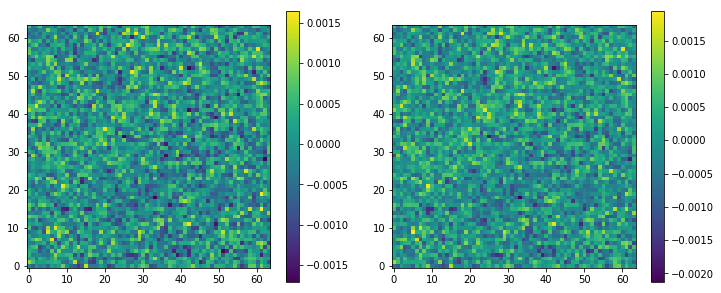

In [38]:
vz_mean = v_z.mean(axis=0)
mom1_z = (v_z*field).sum(axis=0)/field.sum(axis=0)
pl.figure(figsize=(12,5))
ax1 = pl.subplot(1,2,1)
im1 = ax1.imshow(vz_mean.value)
pl.colorbar(mappable=im1)
ax2 = pl.subplot(1,2,2)
im2 = ax2.imshow(mom1_z.value)
pl.colorbar(mappable=im2)

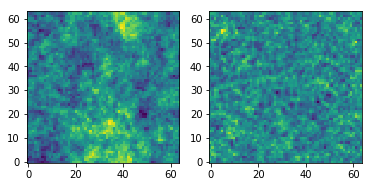

In [39]:
pl.subplot(1,2,1)
pl.imshow(field[0,:,:])
pl.subplot(1,2,2)
pl.imshow(g_z[0,:,:].value)

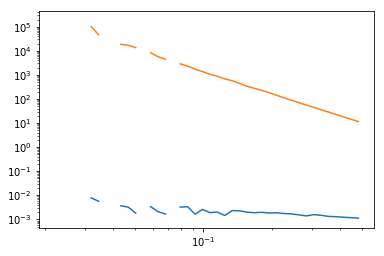

In [40]:
f,p = psds.pspec(np.abs(np.fft.fftshift(np.fft.fft2(mom1_z.value)**2)))
pl.loglog(f, p)

f,p = psds.pspec(np.abs(np.fft.fftshift(np.fft.fft2(mom0)**2)))
pl.loglog(f, p)

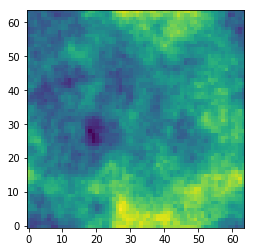

In [31]:
pl.imshow(mom0)